In [1]:
import sys
sys.path.append("./tools")

In [2]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.visualization import plot_bloch_multivector, plot_histogram

simulator = Aer.get_backend('qasm_simulator')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
palette = {
    'unitary': '#FF9966', 'vqc': '#66CC99', 
}

In [5]:
%matplotlib inline

## Tool Modules

In [6]:
from unitary import *
from VQC import *

from dataSL import *#

## Prepare Circuits

### - input circuit

In [7]:
def initCircuit(n):
    circuit = QuantumCircuit(2 * n, 2 * n)
    senders = circuit.qubits[0:n]
    receivers = circuit.qubits[n:]
    
    for sender, receiver in zip(senders, receivers):
        circuit.h(sender)
        circuit.cx(sender, receiver)
        
    return senders, receivers, circuit

In [8]:
def operate(circuit, target, bits):
    """
        => Z^(b_1) * X^(b_2)
    """
    if bits[0] == '1':
        circuit.z(target)
    if bits[1] == '1':
        circuit.x(target)

    return circuit

def getCircuit(n, classical_bits):
    bits_str = ''.join(classical_bits)
    """
        getCircuit(circuit, ["01", "10", "00"])
            => X(A1), Z(A2), I(A3)
    """
    senders, receivers, circuit = initCircuit(n)
    circuit_copy = circuit.copy()
    
    circuit_copy.barrier(senders)
    for i, sender in enumerate(senders):
        operate(circuit_copy, sender, classical_bits[i])

    return circuit_copy

### - target circuit

In [9]:
def getTargetCircuit(strategy, n, p, pos):
    circuit = QuantumCircuit(2 * n, 2 * n)
    
    if strategy == 'vqc':
        circuit = getVQCCircuit(circuit, n, p, pos)
    elif strategy == 'unitary':
        unitary = buildU(n, p)
        circuit.append(unitary, pos)
        
    return circuit

### - Output Circuits

In [10]:
def getMeasureCircuit(n):
    circuit = QuantumCircuit(2 * n, 2 * n)
    
    for i in range(n):
        circuit.cx(i, i + n)
        circuit.h(i)
    
    return circuit

### - Full Circuit

In [13]:
def getFullCircuit(strategy, n, bits, p):
    inputCircuit = getCircuit(n, bits)
    inputCircuit.barrier()
    
    targetCircuit = getTargetCircuit(strategy, n, p, list(range(n)))
    targetCircuit.barrier()
    
    outputCircuit = getMeasureCircuit(n)
    
    return inputCircuit.compose(targetCircuit).compose(outputCircuit)

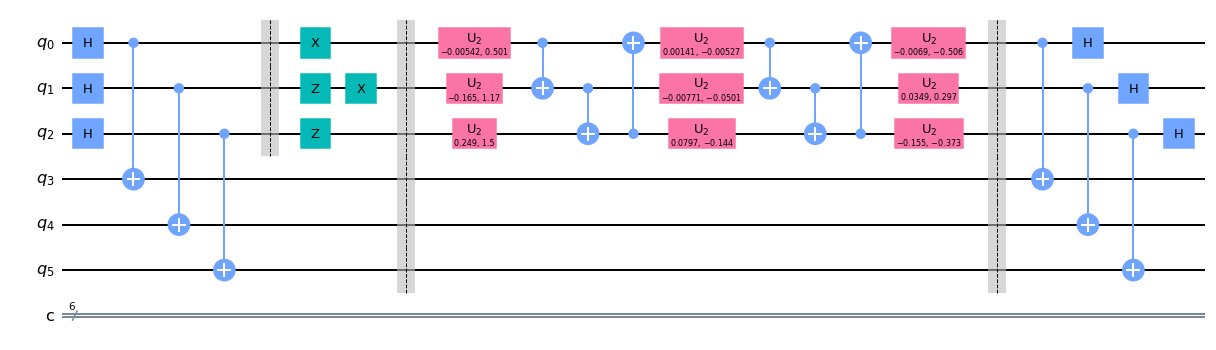

In [14]:
qc = getFullCircuit('vqc', 3, ['01', '11', "10"], loadParams('sdc3', 'vqc', 4))
qc.draw(output='mpl')

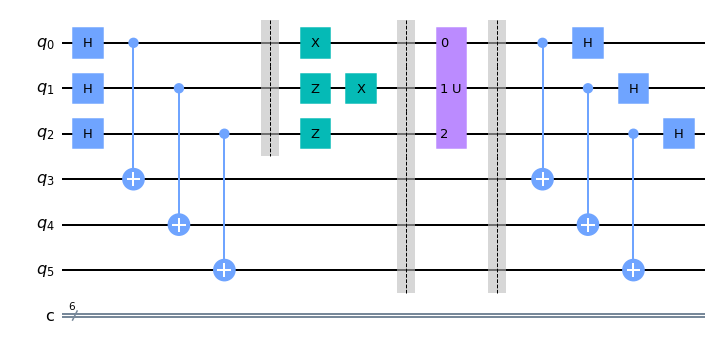

In [15]:
qc = getFullCircuit('unitary', 3, ['01', '11', "10"], loadParams('sdc3', 'unitary', 4))
qc.draw(output='mpl')

## Validate

### - infos

In [16]:
allInfos = []
classical_bits = ["00", "01", "10", "11"]
for comb in combs[3]:
    allInfos.append(list(map( lambda x: classical_bits[int(x)] , list(comb))))

print(allInfos)
print(len(allInfos))

[['00', '00', '00'], ['00', '00', '01'], ['00', '00', '10'], ['00', '00', '11'], ['00', '01', '00'], ['00', '01', '01'], ['00', '01', '10'], ['00', '01', '11'], ['00', '10', '00'], ['00', '10', '01'], ['00', '10', '10'], ['00', '10', '11'], ['00', '11', '00'], ['00', '11', '01'], ['00', '11', '10'], ['00', '11', '11'], ['01', '00', '00'], ['01', '00', '01'], ['01', '00', '10'], ['01', '00', '11'], ['01', '01', '00'], ['01', '01', '01'], ['01', '01', '10'], ['01', '01', '11'], ['01', '10', '00'], ['01', '10', '01'], ['01', '10', '10'], ['01', '10', '11'], ['01', '11', '00'], ['01', '11', '01'], ['01', '11', '10'], ['01', '11', '11'], ['10', '00', '00'], ['10', '00', '01'], ['10', '00', '10'], ['10', '00', '11'], ['10', '01', '00'], ['10', '01', '01'], ['10', '01', '10'], ['10', '01', '11'], ['10', '10', '00'], ['10', '10', '01'], ['10', '10', '10'], ['10', '10', '11'], ['10', '11', '00'], ['10', '11', '01'], ['10', '11', '10'], ['10', '11', '11'], ['11', '00', '00'], ['11', '00', '01'],

In [17]:
infos_example = ["11", "01", "10"]

### - statistic

In [18]:
def statisticCount(counts):
    dict1 = {'00': 0, '01': 0, '10': 0, '11': 0}
    dict2 = {'00': 0, '01': 0, '10': 0, '11': 0}
    dict3 = {'00': 0, '01': 0, '10': 0, '11': 0}

    for key in counts:
        # dict[key[:2]]
        dict1[ key[:2] ] += counts[key]
        dict2[ key[2:4] ] += counts[key]
        dict3[ key[4:6] ] += counts[key]

    stds = np.array([
        np.std(list(dict1.values())),
        np.std(list(dict2.values())),
        np.std(list(dict3.values())),
    ])
    
    print(f'1: {dict1}, std: {stds[0]}')
    print(f'2: {dict2}, std: {stds[1]}')
    print(f'3: {dict3}, std: {stds[2]}')
    
    return stds

In [19]:
def stat(circuit, shots=1000):
    circuit = circuit.copy()
    circuit.measure([0, 3, 1, 4, 2, 5], [5, 4, 3, 2, 1, 0])
    
    job = execute(circuit, simulator, shots = shots)
    results = job.result()
    counts = results.get_counts(circuit)
    
    print(counts)
    print()
    statisticCount(counts)

In [24]:
def statAll(strategy, circuitFactory, infos, *, shots=1000, params=None):
    stds = np.array([0.0, 0.0, 0.0])
    
    for i, info in enumerate(infos):
        print(f'No. {i + 1}: info: {info}\n')
        
        if not isinstance(params, type(None)):
            circuit = circuitFactory(strategy, 3, info, params)
        else:
            circuit = circuitFactory(strategy, 3, info)
        circuit.measure([0, 3, 1, 4, 2, 5], [5, 4, 3, 2, 1, 0])

        job = execute(circuit, simulator, shots = shots)
        results = job.result()
        counts = results.get_counts(circuit)
        
        stds += statisticCount(counts)
        print()
    
    print('-' * 64)
    print('Average: ', stds / 64)

In [25]:
def getCounts(circuit, shots=1000):
    circuit = circuit.copy()
    circuit.measure([0, 3, 1, 4, 2, 5], [5, 4, 3, 2, 1, 0])
    
    job = execute(circuit, simulator, shots = shots)
    results = job.result()
    counts = results.get_counts(circuit)
    
    return counts

## Test: Unitary

In [54]:
best_unitary_params = loadParams('sdc3', 'unitary', 5)

In [26]:
statAll('unitary', getFullCircuit, allInfos, shots=10000, params=best_unitary_params)

No. 1: info: ['00', '00', '00']

1: {'00': 2636, '01': 2325, '10': 2440, '11': 2599}, std: 125.02199806434066
2: {'00': 2193, '01': 2461, '10': 2701, '11': 2645}, std: 198.23975383358405
3: {'00': 2478, '01': 2354, '10': 2642, '11': 2526}, std: 103.24727599312246

No. 2: info: ['00', '00', '01']

1: {'00': 2687, '01': 2366, '10': 2423, '11': 2524}, std: 121.89134505780137
2: {'00': 2241, '01': 2561, '10': 2596, '11': 2602}, std: 150.35125539881602
3: {'00': 2425, '01': 2394, '10': 2567, '11': 2614}, std: 92.66336924588917

No. 3: info: ['00', '00', '10']

1: {'00': 2627, '01': 2312, '10': 2396, '11': 2665}, std: 149.59445176877384
2: {'00': 2258, '01': 2458, '10': 2615, '11': 2669}, std: 159.77640626825976
3: {'00': 2630, '01': 2501, '10': 2473, '11': 2396}, std: 84.3297100670932

No. 4: info: ['00', '00', '11']

1: {'00': 2705, '01': 2292, '10': 2404, '11': 2599}, std: 161.48219716117316
2: {'00': 2221, '01': 2488, '10': 2701, '11': 2590}, std: 177.8243515382525
3: {'00': 2633, '01': 

1: {'00': 2275, '01': 2675, '10': 2664, '11': 2386}, std: 174.02729670945303
2: {'00': 2534, '01': 2684, '10': 2542, '11': 2240}, std: 161.53637361288014
3: {'00': 2432, '01': 2634, '10': 2380, '11': 2554}, std: 99.86991538997117

No. 33: info: ['10', '00', '00']

1: {'00': 2397, '01': 2666, '10': 2607, '11': 2330}, std: 140.10174873997826
2: {'00': 2260, '01': 2504, '10': 2672, '11': 2564}, std: 151.07613974417006
3: {'00': 2478, '01': 2398, '10': 2607, '11': 2517}, std: 75.20970682033004

No. 34: info: ['10', '00', '01']

1: {'00': 2473, '01': 2587, '10': 2596, '11': 2344}, std: 102.28636272739392
2: {'00': 2179, '01': 2565, '10': 2707, '11': 2549}, std: 195.26648457940755
3: {'00': 2406, '01': 2408, '10': 2586, '11': 2600}, std: 93.13431161500041

No. 35: info: ['10', '00', '10']

1: {'00': 2468, '01': 2551, '10': 2682, '11': 2299}, std: 138.8794441233115
2: {'00': 2270, '01': 2501, '10': 2631, '11': 2598}, std: 141.12583037842506
3: {'00': 2587, '01': 2519, '10': 2432, '11': 2462},

1: {'00': 2583, '01': 2450, '10': 2371, '11': 2596}, std: 93.86959039007255
2: {'00': 2575, '01': 2731, '10': 2487, '11': 2207}, std: 190.39695375714393
3: {'00': 2484, '01': 2576, '10': 2451, '11': 2489}, std: 46.24391851908746

----------------------------------------------------------------
Average:  [137.15591855 165.17292327  81.08724547]


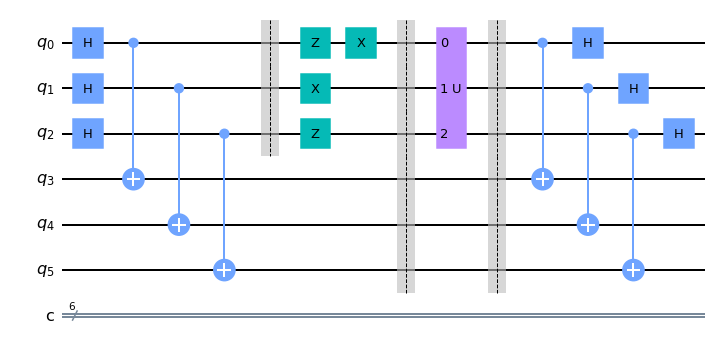

In [55]:
unitary_circuit = getFullCircuit('unitary', 3, infos_example, best_unitary_params)
unitary_circuit.draw(output='mpl')

In [56]:
stat(unitary_circuit, shots=10000)

{'010001': 166, '110000': 159, '000111': 153, '100100': 188, '111100': 180, '001101': 210, '111011': 108, '100101': 171, '001110': 151, '010111': 94, '100010': 102, '111110': 95, '001011': 166, '011100': 227, '000001': 91, '101010': 164, '110110': 210, '011011': 203, '101000': 202, '011000': 196, '001000': 229, '011010': 174, '101111': 193, '000110': 171, '110001': 119, '010011': 143, '111111': 168, '100001': 169, '001010': 133, '000101': 166, '110010': 80, '101110': 193, '011111': 214, '110111': 161, '000000': 167, '000011': 136, '110100': 229, '101100': 143, '101001': 199, '000100': 108, '101101': 138, '110011': 173, '111010': 86, '100110': 161, '001111': 135, '101011': 145, '000010': 205, '110101': 174, '010101': 204, '111001': 222, '100011': 140, '001100': 102, '111101': 149, '100000': 154, '010000': 124, '111000': 140, '011110': 120, '100111': 212, '011101': 122, '010010': 104, '011001': 110, '010100': 224, '010110': 101, '001001': 24}

1: {'00': 2347, '01': 2526, '10': 2674, '11'

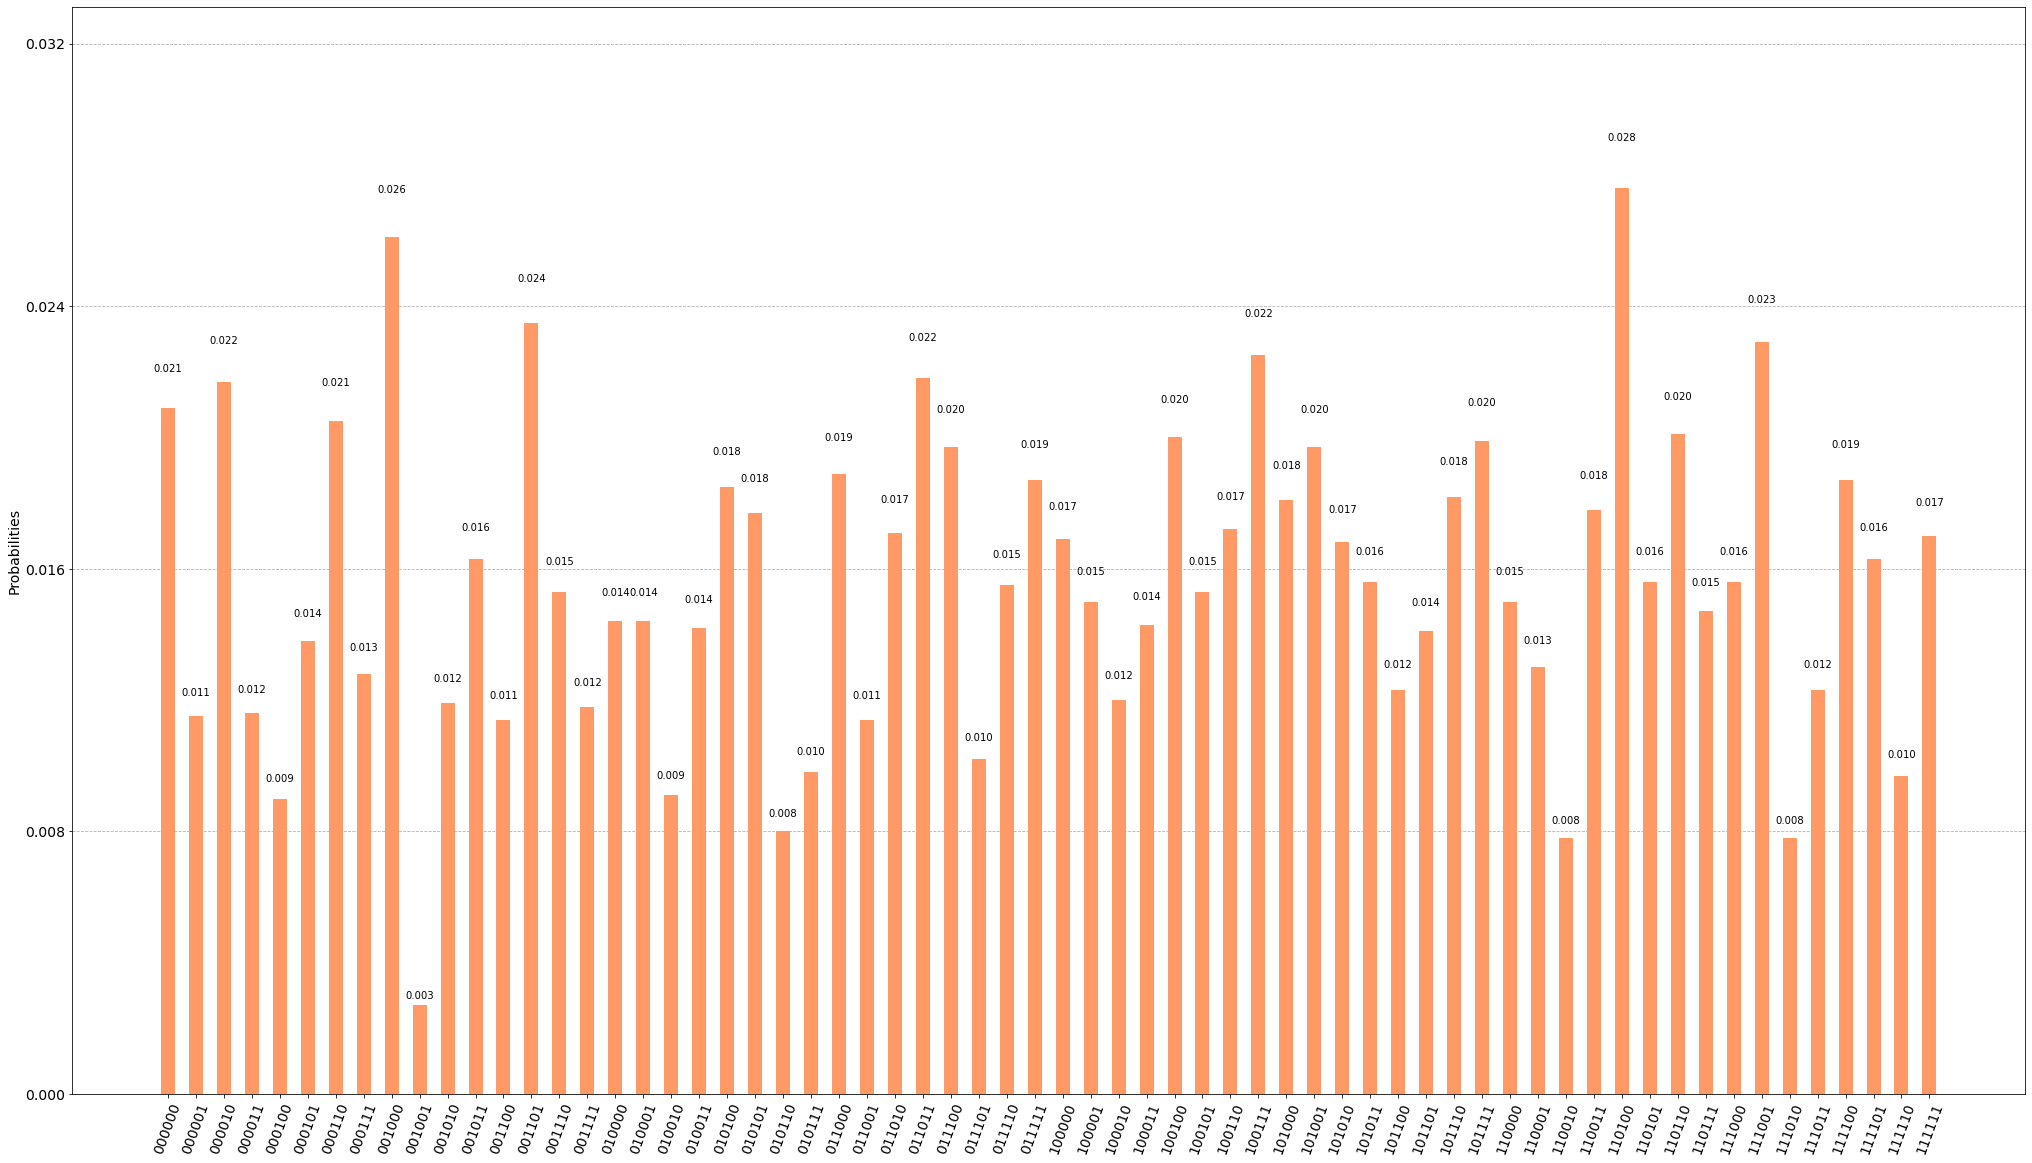

In [57]:
plot_histogram(getCounts(unitary_circuit, shots=10000), figsize=(35, 20), color=palette['unitary'])

## Test: VQC

In [58]:
best_vqc_params = loadParams('sdc3', 'vqc', 1)

In [48]:
statAll('vqc', getFullCircuit, allInfos, shots=10000, params=best_vqc_params)

No. 1: info: ['00', '00', '00']

1: {'00': 2507, '01': 2481, '10': 2520, '11': 2492}, std: 14.781745499094482
2: {'00': 2471, '01': 2555, '10': 2462, '11': 2512}, std: 36.92560087527351
3: {'00': 2407, '01': 2577, '10': 2483, '11': 2533}, std: 63.15853069855251

No. 2: info: ['00', '00', '01']

1: {'00': 2501, '01': 2547, '10': 2448, '11': 2504}, std: 35.106979363083916
2: {'00': 2504, '01': 2596, '10': 2436, '11': 2464}, std: 60.4648658313239
3: {'00': 2477, '01': 2471, '10': 2520, '11': 2532}, std: 26.42915057280502

No. 3: info: ['00', '00', '10']

1: {'00': 2570, '01': 2399, '10': 2525, '11': 2506}, std: 62.773402010724254
2: {'00': 2487, '01': 2438, '10': 2545, '11': 2530}, std: 41.6473288459176
3: {'00': 2527, '01': 2487, '10': 2433, '11': 2553}, std: 45.2658811910251

No. 4: info: ['00', '00', '11']

1: {'00': 2536, '01': 2430, '10': 2540, '11': 2494}, std: 44.24929377967517
2: {'00': 2447, '01': 2505, '10': 2540, '11': 2508}, std: 33.53356527421443
3: {'00': 2493, '01': 2406, '

1: {'00': 2527, '01': 2474, '10': 2508, '11': 2491}, std: 19.685019685029527
2: {'00': 2527, '01': 2441, '10': 2489, '11': 2543}, std: 39.30648801406709
3: {'00': 2493, '01': 2518, '10': 2491, '11': 2498}, std: 10.700467279516348

No. 33: info: ['10', '00', '00']

1: {'00': 2580, '01': 2530, '10': 2450, '11': 2440}, std: 57.879184513951124
2: {'00': 2518, '01': 2523, '10': 2491, '11': 2468}, std: 22.124646889837585
3: {'00': 2477, '01': 2504, '10': 2459, '11': 2560}, std: 38.16411927452276

No. 34: info: ['10', '00', '01']

1: {'00': 2569, '01': 2505, '10': 2540, '11': 2386}, std: 69.60962577115323
2: {'00': 2562, '01': 2473, '10': 2499, '11': 2466}, std: 37.84838173555112
3: {'00': 2515, '01': 2511, '10': 2498, '11': 2476}, std: 15.215124054702938

No. 35: info: ['10', '00', '10']

1: {'00': 2537, '01': 2539, '10': 2498, '11': 2426}, std: 45.743852045930716
2: {'00': 2510, '01': 2436, '10': 2542, '11': 2512}, std: 39.06404996924922
3: {'00': 2560, '01': 2530, '10': 2461, '11': 2449}, 

1: {'00': 2486, '01': 2504, '10': 2503, '11': 2507}, std: 8.215838362577491
2: {'00': 2470, '01': 2509, '10': 2552, '11': 2469}, std: 34.08078637590395
3: {'00': 2462, '01': 2446, '10': 2518, '11': 2574}, std: 50.39841267341661

----------------------------------------------------------------
Average:  [39.60382598 40.66742684 42.16507811]


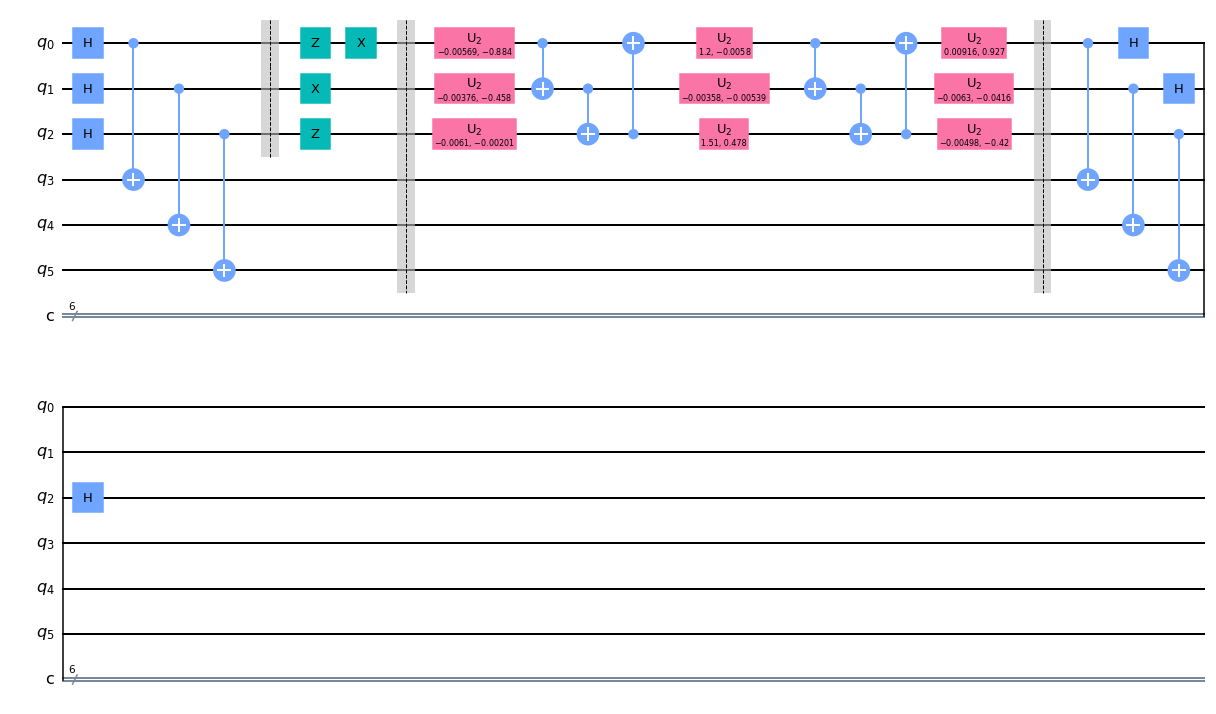

In [59]:
vqc_circuit = getFullCircuit('vqc', 3, infos_example, best_vqc_params)
vqc_circuit.draw(output='mpl')

In [60]:
stat(vqc_circuit, shots=10000)

{'110111': 133, '000000': 156, '000101': 142, '101110': 144, '110010': 202, '010101': 143, '000100': 169, '110011': 139, '101101': 228, '110000': 107, '000111': 190, '100111': 156, '010000': 135, '011100': 193, '111010': 195, '001111': 169, '100110': 172, '010110': 134, '111100': 135, '001101': 124, '100100': 180, '110100': 138, '000011': 195, '101100': 141, '011011': 172, '001100': 198, '111101': 146, '100011': 136, '010001': 136, '110101': 171, '101011': 131, '000010': 150, '101010': 188, '110110': 140, '000001': 133, '011111': 182, '011001': 127, '011000': 184, '111110': 200, '001011': 179, '100010': 150, '111001': 171, '001010': 147, '100001': 186, '111111': 137, '110001': 153, '000110': 123, '101111': 123, '010011': 206, '100000': 125, '010010': 169, '010100': 181, '111000': 149, '100101': 164, '001110': 159, '111011': 149, '011010': 121, '001000': 129, '001001': 120, '101000': 158, '010111': 152, '011101': 163, '011110': 126, '101001': 146}

1: {'00': 2483, '01': 2524, '10': 2528

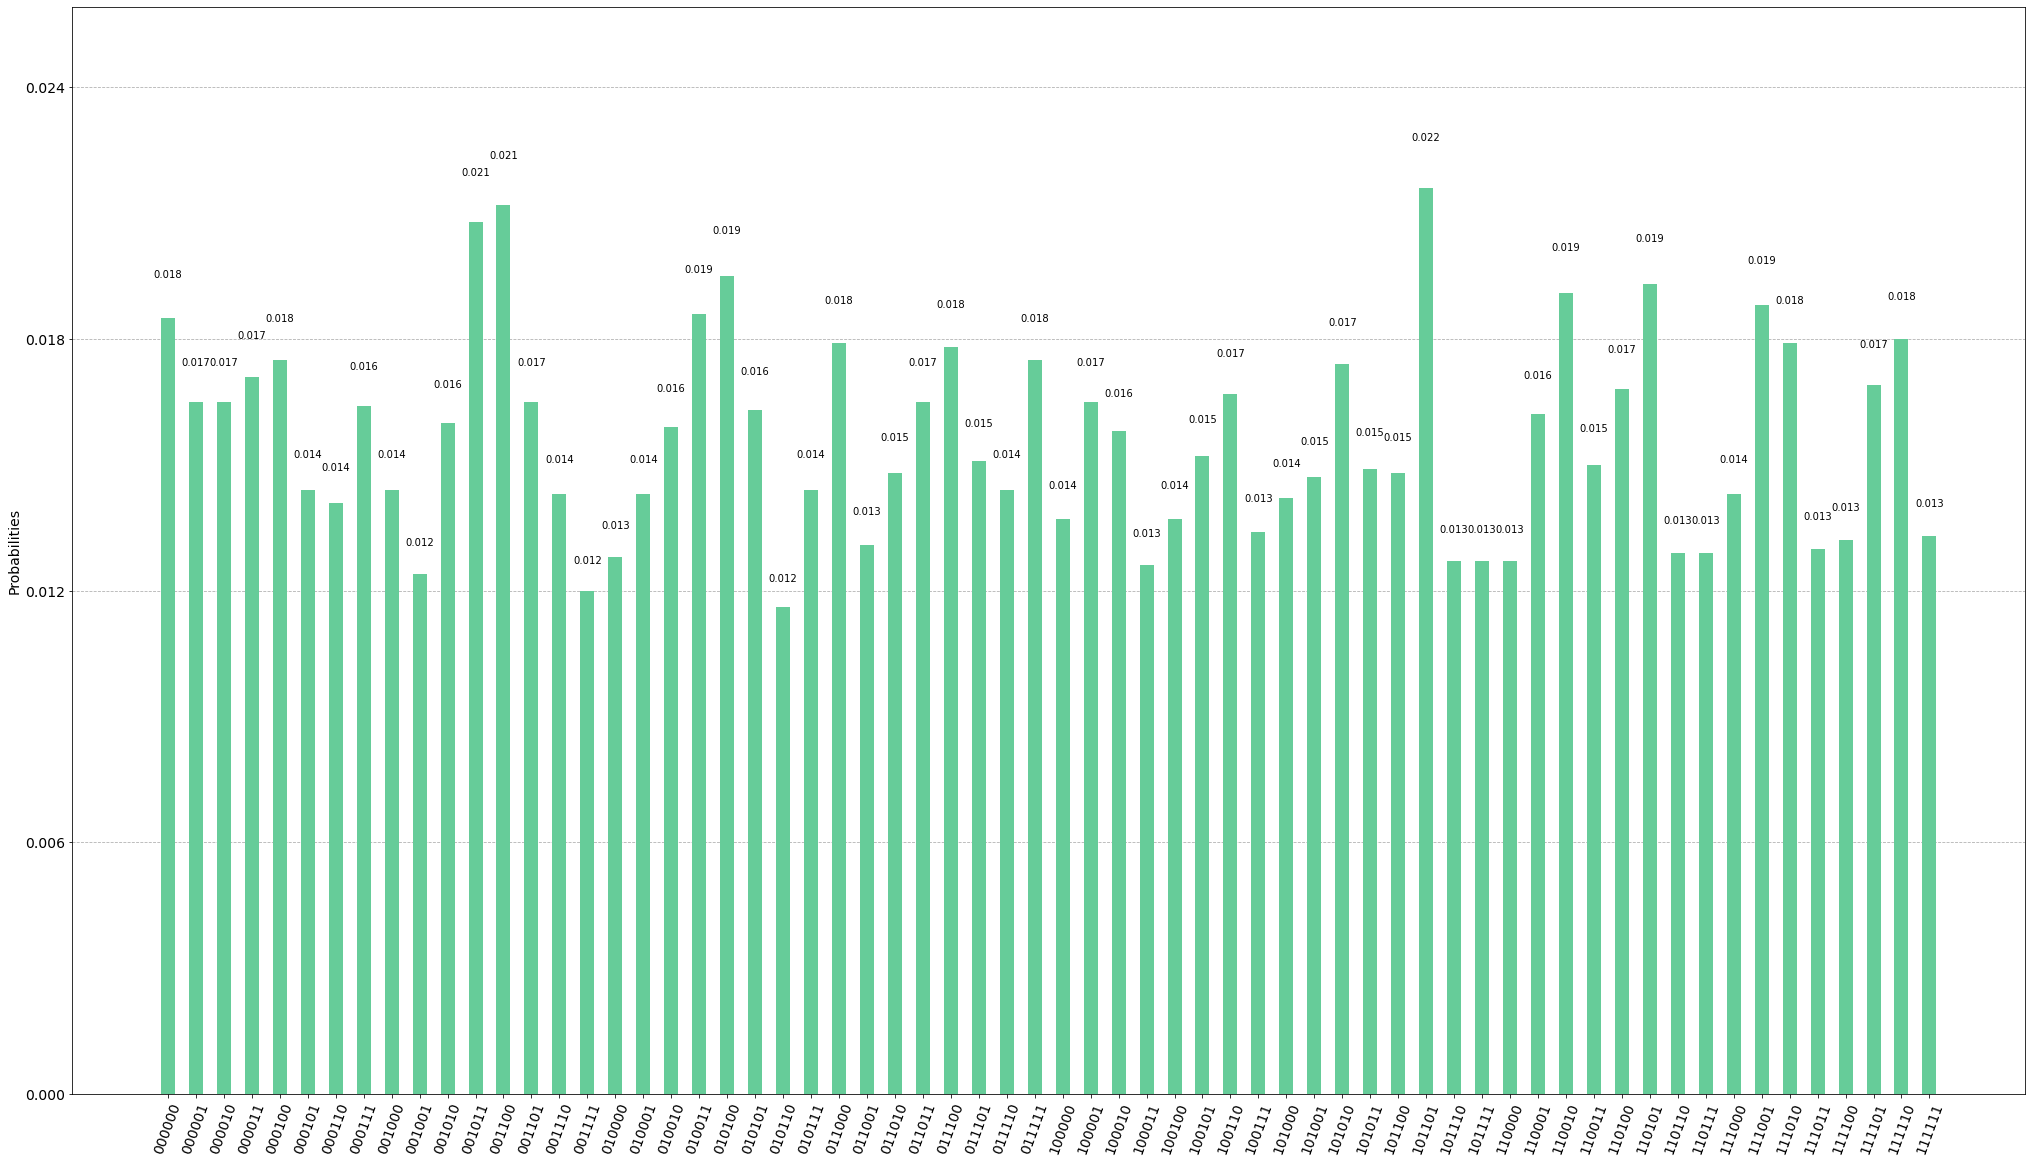

In [61]:
plot_histogram(getCounts(vqc_circuit, shots=10000), figsize=(35,20), color=palette['vqc'])